/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/home/eng/workspace/ML-wireless-signal-classification/src/ml_wireless_classification/base/SignalUtils.py:175: RuntimeWarning: invalid value encountered in log
  decay_rate = -np.gradient(np.log(normalized_autocorr + 1e-10))


SNR: -20.0 dB, Accuracy: 9.90%
SNR: -18.0 dB, Accuracy: 9.93%
SNR: -16.0 dB, Accuracy: 11.32%
SNR: -14.0 dB, Accuracy: 15.88%
SNR: -12.0 dB, Accuracy: 20.17%
SNR: -10.0 dB, Accuracy: 28.62%
SNR: -8.0 dB, Accuracy: 38.41%
SNR: -6.0 dB, Accuracy: 49.14%
SNR: -4.0 dB, Accuracy: 58.55%
SNR: -2.0 dB, Accuracy: 65.57%
SNR: 0.0 dB, Accuracy: 72.20%
SNR: 2.0 dB, Accuracy: 73.89%
SNR: 4.0 dB, Accuracy: 76.49%
SNR: 6.0 dB, Accuracy: 74.83%
SNR: 8.0 dB, Accuracy: 74.26%
SNR: 10.0 dB, Accuracy: 76.02%
SNR: 12.0 dB, Accuracy: 77.51%
SNR: 14.0 dB, Accuracy: 75.21%
SNR: 16.0 dB, Accuracy: 75.62%
SNR: 18.0 dB, Accuracy: 77.36%


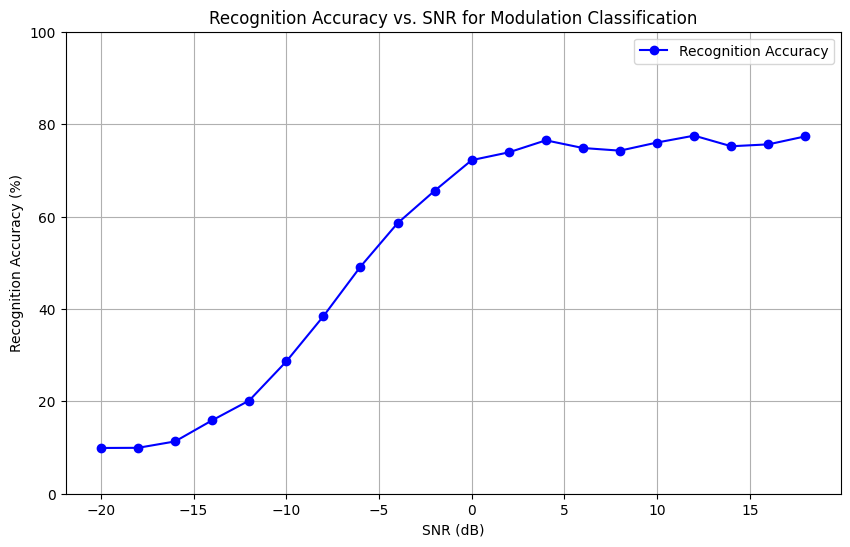

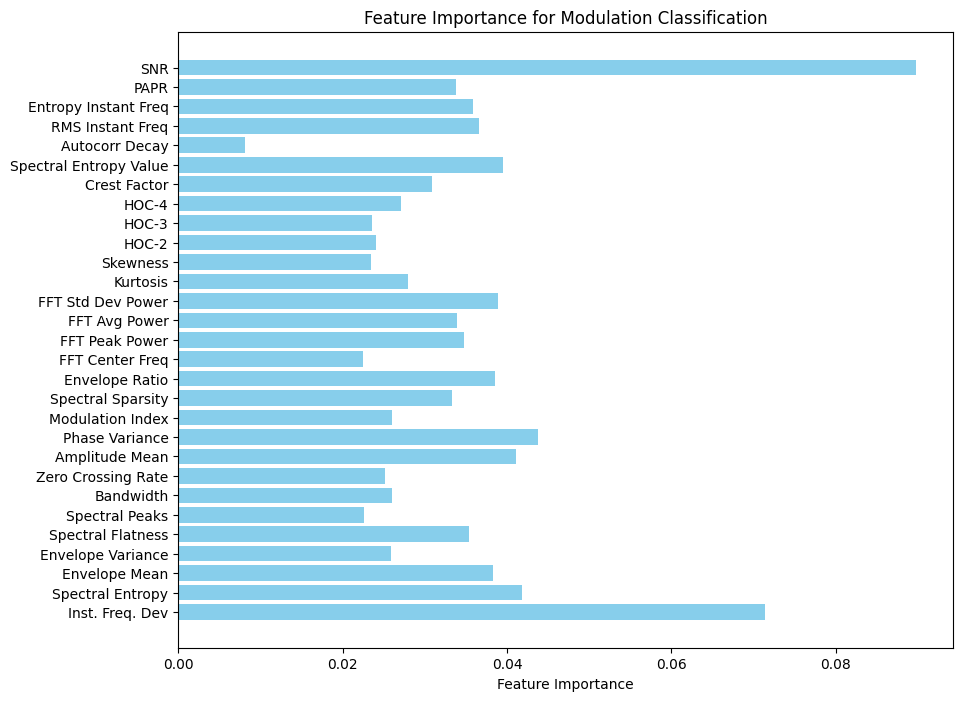

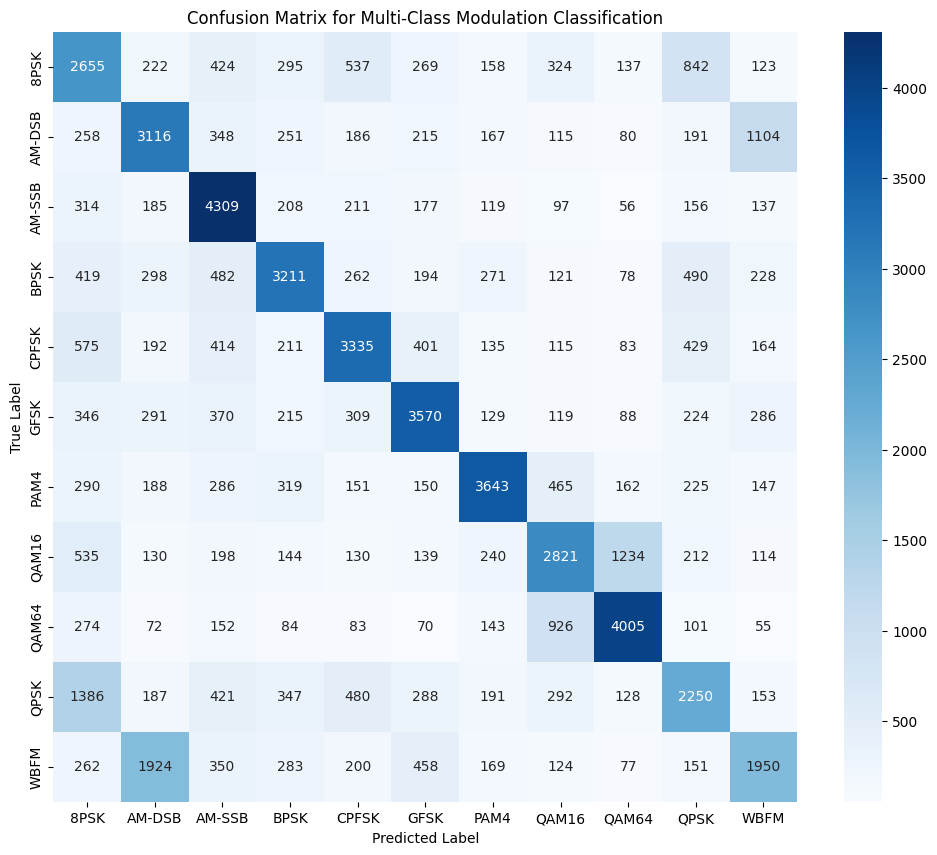

Classification Report for Modulation Types:
              precision    recall  f1-score   support

        8PSK       0.36      0.44      0.40      5986
      AM-DSB       0.46      0.52      0.49      6031
      AM-SSB       0.56      0.72      0.63      5969
        BPSK       0.58      0.53      0.55      6054
       CPFSK       0.57      0.55      0.56      6054
        GFSK       0.60      0.60      0.60      5947
        PAM4       0.68      0.60      0.64      6026
       QAM16       0.51      0.48      0.49      5897
       QAM64       0.65      0.67      0.66      5965
        QPSK       0.43      0.37      0.39      6123
        WBFM       0.44      0.33      0.37      5948

    accuracy                           0.53     66000
   macro avg       0.53      0.53      0.53     66000
weighted avg       0.53      0.53      0.53     66000



In [1]:
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from ml_wireless_classification.base.SignalUtils import (
    compute_instantaneous_features, compute_modulation_index, compute_spectral_asymmetry,
    instantaneous_frequency_deviation, spectral_entropy, envelope_mean_variance,
    spectral_flatness, spectral_peaks_bandwidth, zero_crossing_rate, compute_fft_features,
    autocorrelation, is_digital_signal, compute_kurtosis, compute_skewness,
    compute_spectral_energy_concentration, compute_instantaneous_frequency_jitter,
    compute_spectral_kurtosis, compute_higher_order_cumulants, compute_crest_factor,
    compute_spectral_entropy, compute_energy_spread, compute_autocorrelation_decay,
    compute_rms_of_instantaneous_frequency, compute_entropy_of_instantaneous_frequency,
    compute_envelope_variance, compute_papr
)

# Global dictionary to store feature names and values
feature_dict = {}

def add_feature(name, func, *args):
    """Try to add a feature by checking the shape and ensuring it’s a scalar."""
    try:
        value = func(*args)
        # If value is an array, check if it is scalar (single value)
        if np.isscalar(value) or (isinstance(value, np.ndarray) and value.size == 1):
            feature_dict[name] = value.item() if isinstance(value, np.ndarray) else value
        else:
            print(f"Warning: Feature '{name}' has incorrect shape and was not added.")
    except Exception as e:
        print(f"Error computing feature '{name}': {e}")

def extract_features(data):
    features = []
    labels = []
    snrs = []

    for key, signals in data.items():
        mod_type, snr = key
        for signal in signals:
            real_part, imag_part = signal[0], signal[1]
            complex_signal = real_part + 1j * imag_part

            # Reset feature dictionary for each signal
            global feature_dict
            feature_dict = {}

            # Add features with validation
            add_feature("Inst. Freq. Dev", instantaneous_frequency_deviation, complex_signal)
            add_feature("Spectral Entropy", spectral_entropy, real_part)
            add_feature("Envelope Mean", lambda x: envelope_mean_variance(x)[0], real_part)
            add_feature("Envelope Variance", lambda x: envelope_mean_variance(x)[1], real_part)
            add_feature("Spectral Flatness", spectral_flatness, real_part)
            add_feature("Spectral Peaks", lambda x: spectral_peaks_bandwidth(x)[0], real_part)
            add_feature("Bandwidth", lambda x: spectral_peaks_bandwidth(x)[1], real_part)
            add_feature("Zero Crossing Rate", zero_crossing_rate, real_part)
            add_feature("Amplitude Mean", lambda x: np.mean(compute_instantaneous_features(x)[0]), real_part)
            add_feature("Phase Variance", lambda x: np.var(compute_instantaneous_features(x)[1]), real_part)
            add_feature("Modulation Index", compute_modulation_index, real_part)
            add_feature("Spectral Sparsity", compute_spectral_asymmetry, real_part)
            add_feature("Envelope Ratio", lambda x: envelope_mean_variance(x)[0] / (envelope_mean_variance(x)[1] + 1e-10), real_part)
            add_feature("FFT Center Freq", lambda x: compute_fft_features(x)[0], real_part)
            add_feature("FFT Peak Power", lambda x: compute_fft_features(x)[1], real_part)
            add_feature("FFT Avg Power", lambda x: compute_fft_features(x)[2], real_part)
            add_feature("FFT Std Dev Power", lambda x: compute_fft_features(x)[3], real_part)
            add_feature("Kurtosis", compute_kurtosis, real_part)
            add_feature("Skewness", compute_skewness, real_part)
            add_feature("HOC-2", lambda x: compute_higher_order_cumulants(x, order=2), real_part)
            add_feature("HOC-3", lambda x: compute_higher_order_cumulants(x, order=3), real_part)
            add_feature("HOC-4", lambda x: compute_higher_order_cumulants(x, order=4), real_part)
            add_feature("Crest Factor", compute_crest_factor, real_part)
            add_feature("Spectral Entropy Value", compute_spectral_entropy, real_part)
            add_feature("Autocorr Decay", compute_autocorrelation_decay, real_part)
            add_feature("RMS Instant Freq", compute_rms_of_instantaneous_frequency, real_part)
            add_feature("Entropy Instant Freq", compute_entropy_of_instantaneous_frequency, real_part)
            add_feature("Envelope Variance", compute_envelope_variance, real_part)
            add_feature("PAPR", compute_papr, real_part)

            # Add SNR as a feature
            feature_dict["SNR"] = snr  # Include SNR as part of the features

            # Append the feature values and label
            features.append(list(feature_dict.values()))
            labels.append(mod_type)

    return np.array(features), labels

# Load the RML2016.10a_dict.pkl file with explicit encoding
with open("../RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# Feature extraction for all signals
features, labels = extract_features(data)

# Encode labels for classification
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.3, random_state=42)

# Train a single classifier on the entire dataset for multi-class classification
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate accuracy for each SNR level
unique_snrs = sorted(set(X_test[:, -1]))  # Get unique SNR levels from test set
accuracy_per_snr = []

for snr in unique_snrs:
    # Select samples with the current SNR
    snr_indices = np.where(X_test[:, -1] == snr)
    X_snr = X_test[snr_indices]
    y_snr = y_test[snr_indices]

    # Predict and calculate accuracy
    y_pred = clf.predict(X_snr)
    accuracy = accuracy_score(y_snr, y_pred)
    accuracy_per_snr.append(accuracy * 100)  # Convert to percentage

    print(f"SNR: {snr} dB, Accuracy: {accuracy * 100:.2f}%")

# Plot Recognition Accuracy vs. SNR
plt.figure(figsize=(10, 6))
plt.plot(unique_snrs, accuracy_per_snr, 'b-o', label='Recognition Accuracy')
plt.xlabel("SNR (dB)")
plt.ylabel("Recognition Accuracy (%)")
plt.title("Recognition Accuracy vs. SNR for Modulation Classification")
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()

# Feature importance for the classifier
feature_names = list(feature_dict.keys())
importances = clf.feature_importances_
plt.figure(figsize=(10, 8))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Modulation Classification")
plt.show()

# Confusion matrix for overall test set
y_pred_test = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Multi-Class Modulation Classification")
plt.show()

# Print Classification Report
print("Classification Report for Modulation Types:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))


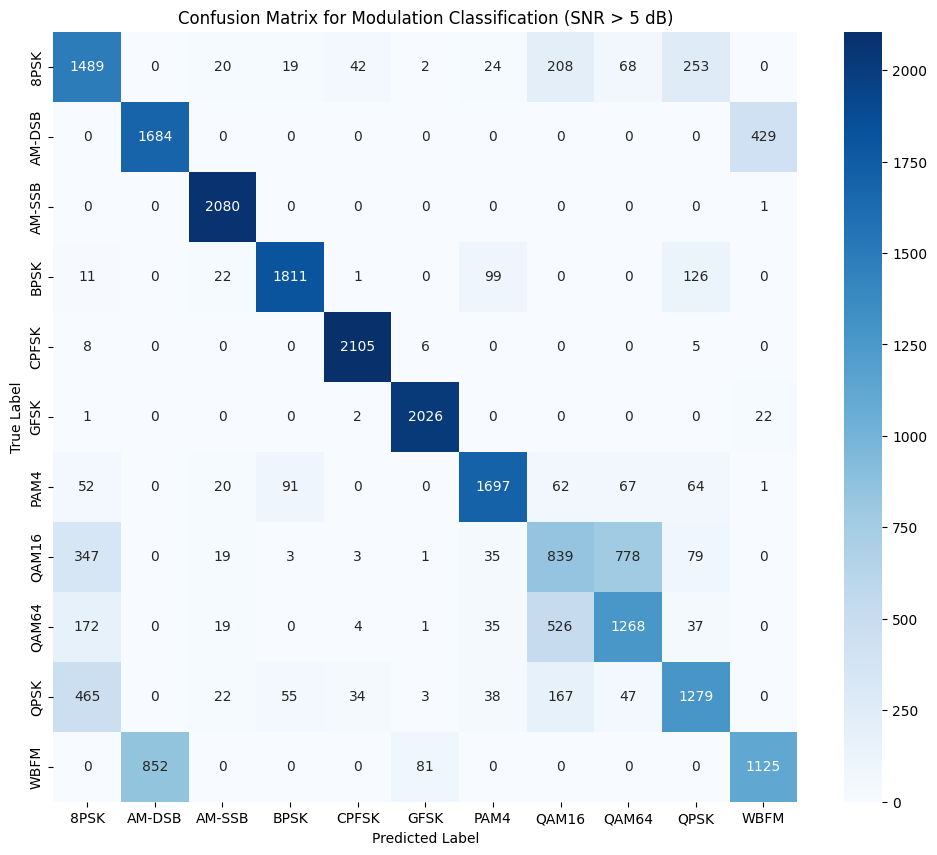

Classification Report for Modulation Types (SNR > 5 dB):
              precision    recall  f1-score   support

        8PSK       0.59      0.70      0.64      2125
      AM-DSB       0.66      0.80      0.72      2113
      AM-SSB       0.94      1.00      0.97      2081
        BPSK       0.92      0.87      0.89      2070
       CPFSK       0.96      0.99      0.98      2124
        GFSK       0.96      0.99      0.97      2051
        PAM4       0.88      0.83      0.85      2054
       QAM16       0.47      0.40      0.43      2104
       QAM64       0.57      0.61      0.59      2062
        QPSK       0.69      0.61      0.65      2110
        WBFM       0.71      0.55      0.62      2058

    accuracy                           0.76     22952
   macro avg       0.76      0.76      0.76     22952
weighted avg       0.76      0.76      0.76     22952



In [2]:
# Filter test samples with SNR > 5 dB
snr_above_5_indices = np.where(X_test[:, -1] > 5)  # Select indices where SNR > 5
X_test_snr_above_5 = X_test[snr_above_5_indices]
y_test_snr_above_5 = y_test[snr_above_5_indices]

# Predict on this subset of data
y_pred_snr_above_5 = clf.predict(X_test_snr_above_5)

# Plot confusion matrix for SNR > 5 dB
conf_matrix_snr_above_5 = confusion_matrix(y_test_snr_above_5, y_pred_snr_above_5)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_snr_above_5, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Modulation Classification (SNR > 5 dB)")
plt.show()

# Print Classification Report for SNR > 5 dB
print("Classification Report for Modulation Types (SNR > 5 dB):")
print(classification_report(y_test_snr_above_5, y_pred_snr_above_5, target_names=label_encoder.classes_))
